In [1]:
!pip install simpletransformers==0.51.16

In [2]:
!pip install emoji

     |████████████████████████████████| 170 kB 5.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=e497313e3cf2e40c0dbef3c273efe75739dd6aaeae35783c12f09d64a5195ed4
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, classification_report, log_loss, auc, roc_auc_score, roc_curve, f1_score, precision_recall_curve, recall_score, precision_score
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, BatchNormalization
from keras.models import Model, Sequential, model_from_json, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, Callback, CSVLogger
from keras import backend as K

**DATA**

In [4]:
import xlrd
import csv
def csv_from_Excel(text1, text2):
    wb = xlrd.open_workbook(text1)
    sh = wb.sheet_by_name('Sheet1')
    your_csv_file = open(text2, 'w')
    wr = csv.writer(your_csv_file, quoting=csv.QUOTE_ALL)
    for rownum in range(sh.nrows):
        wr.writerow(sh.row_values(rownum))
    your_csv_file.close()
csv_from_Excel('/content/Constraint_English_Train.xlsx', '/content/dataset_train.csv')
csv_from_Excel('/content/Constraint_English_Val.xlsx', '/content/dataset_val.csv')

In [5]:
from nltk.tokenize import TweetTokenizer
from emoji import demojize
import re

tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = normTweet.replace("cannot ", "can not ").replace("n't ", " n't ").replace("n 't ", " n't ").replace("ca n't", "can't").replace("ai n't", "ain't")
    normTweet = normTweet.replace("'m ", " 'm ").replace("'re ", " 're ").replace("'s ", " 's ").replace("'ll ", " 'll ").replace("'d ", " 'd ").replace("'ve ", " 've ")
    normTweet = normTweet.replace(" p . m .", "  p.m.") .replace(" p . m ", " p.m ").replace(" a . m .", " a.m.").replace(" a . m ", " a.m ")

    normTweet = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet)
    
    return " ".join(normTweet.split())

In [6]:
train_df = pd.read_csv('/content/dataset_train.csv')
train_df.loc[:,'tweet'] = train_df['tweet'].apply(lambda x: normalizeTweet(x))
train_df.loc[:,"label"] = train_df['label'].apply(lambda x: 0 if x == 'fake' else 1)
train_df = train_df.drop(columns='id')
train_df.columns = ["text", "labels"]

val_df = pd.read_csv('/content/dataset_val.csv')
val_df.loc[:,"tweet"] = val_df['tweet'].apply(lambda x: normalizeTweet(x))
val_df.loc[:,"label"] = val_df['label'].apply(lambda x: 0 if x == 'fake' else 1)
val_df = val_df.drop(columns='id')
val_df.columns = ["text", "labels"]

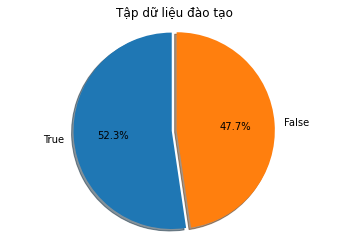

In [7]:
import matplotlib.pyplot as plt

labels = 'True', 'False'
sizes = [3360, 3060]
explode = (0, 0.05) 
fig1, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal') 
ax.set_title("Tập dữ liệu đào tạo")
plt.show()





TRAIN_MODEL


In [8]:
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [9]:
from simpletransformers.classification import ClassificationArgs

model_args = ClassificationArgs()

model_args.reprocess_input_data = True
#model_args.overwrite_output_dir = True

In [10]:
model_args.max_seq_length = 128
model_args.num_train_epochs = 4
model_args.train_batch_size = 32
model_args.learning_rate = 2e-5
model_args.fp16 = False

In [11]:
# Run evaluation periodically during training to monitor progress.
model_args.evaluate_during_training = True

# "Print results from evaluation during training."
model_args.evaluate_during_training_verbose = True

# "Perform evaluation at every specified number of steps. A checkpoint model and
#  the evaluation results will be saved."
model_args.evaluate_during_training_steps = 120

# We only need to tokenize our validation set once, then we can read it from the
# cache.
model_args.use_cached_eval_features = True

In [12]:
# Turn on early stopping.
model_args.use_early_stopping = True

# "The improvement over best_eval_loss necessary to count as a better checkpoint."
model_args.early_stopping_delta = 0.01

# What metric to use in calculating score for evaluation set (plus whether a low
# vs. high value is better for this metric).

#model_args.early_stopping_metric = "mcc"
#model_args.early_stopping_metric_minimize = False

model_args.early_stopping_metric = "eval_loss"
model_args.early_stopping_metric_minimize = True

# "Terminate training after this many evaluations without an improvement in the
#  evaluation metric greater then early_stopping_delta."
model_args.early_stopping_patience = 2

In [13]:
# Increase frequency of validation--from every 120 steps to every 100 steps.
model_args.evaluate_during_training_steps = 100

# Essentially disable early stopping...
model_args.early_stopping_patience = 10

# Turn OFF the validation check between epochs--it's redundant with my "evaluate
# every 40 steps" settings.
model_args.evaluate_each_epoch = False 

# Don't show the evaluation runs--we're just going to rely on wandb for that 
# information.
model_args.evaluate_during_training_verbose = False

In [14]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
#args = ClassificationArgs(num_train_epochs=5)
model = ClassificationModel("bertweet", "vinai/bertweet-covid19-base-cased", num_labels=2, args=model_args) 

DEBUG:filelock:Attempting to acquire lock 140628077952336 on /root/.cache/huggingface/transformers/b0d7660a1cf1cc386b57bf9307b4bc6f23b17e384049be92e2068b42dd6faafc.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d.lock
DEBUG:filelock:Lock 140628077952336 acquired on /root/.cache/huggingface/transformers/b0d7660a1cf1cc386b57bf9307b4bc6f23b17e384049be92e2068b42dd6faafc.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d.lock


Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140628077952336 on /root/.cache/huggingface/transformers/b0d7660a1cf1cc386b57bf9307b4bc6f23b17e384049be92e2068b42dd6faafc.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d.lock
DEBUG:filelock:Lock 140628077952336 released on /root/.cache/huggingface/transformers/b0d7660a1cf1cc386b57bf9307b4bc6f23b17e384049be92e2068b42dd6faafc.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d.lock
DEBUG:filelock:Attempting to acquire lock 140628078641744 on /root/.cache/huggingface/transformers/ab0809f67d77051488b63da3a853d82293dbc8358d01aef03b3390b54d612da7.9e82cf9c093a5e60e05371a1c0531b65a8b3f040d46d1369c15d874b8cbdf8fa.lock
DEBUG:filelock:Lock 140628078641744 acquired on /root/.cache/huggingface/transformers/ab0809f67d77051488b63da3a853d82293dbc8358d01aef03b3390b54d612da7.9e82cf9c093a5e60e05371a1c0531b65a8b3f040d46d1369c15d874b8cbdf8fa.lock


Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140628078641744 on /root/.cache/huggingface/transformers/ab0809f67d77051488b63da3a853d82293dbc8358d01aef03b3390b54d612da7.9e82cf9c093a5e60e05371a1c0531b65a8b3f040d46d1369c15d874b8cbdf8fa.lock
DEBUG:filelock:Lock 140628078641744 released on /root/.cache/huggingface/transformers/ab0809f67d77051488b63da3a853d82293dbc8358d01aef03b3390b54d612da7.9e82cf9c093a5e60e05371a1c0531b65a8b3f040d46d1369c15d874b8cbdf8fa.lock
Some weights of the model checkpoint at vinai/bertweet-covid19-base-cased were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTr

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140628039564816 on /root/.cache/huggingface/transformers/3c6acc8a22458fe4a27ae1add9051cbf7ff985db5787231befd21bf5ee34b043.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982.lock
DEBUG:filelock:Lock 140628039564816 released on /root/.cache/huggingface/transformers/3c6acc8a22458fe4a27ae1add9051cbf7ff985db5787231befd21bf5ee34b043.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982.lock
DEBUG:filelock:Attempting to acquire lock 140628040708816 on /root/.cache/huggingface/transformers/8651b0811f907869b9db76ec3ee744f2fc7692a8ab25b2c96e1a24bcc6b95015.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4.lock
DEBUG:filelock:Lock 140628040708816 acquired on /root/.cache/huggingface/transformers/8651b0811f907869b9db76ec3ee744f2fc7692a8ab25b2c96e1a24bcc6b95015.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4.lock


Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140628040708816 on /root/.cache/huggingface/transformers/8651b0811f907869b9db76ec3ee744f2fc7692a8ab25b2c96e1a24bcc6b95015.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4.lock
DEBUG:filelock:Lock 140628040708816 released on /root/.cache/huggingface/transformers/8651b0811f907869b9db76ec3ee744f2fc7692a8ab25b2c96e1a24bcc6b95015.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4.lock
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
out = model.train_model(train_df, eval_df = val_df)
#model.train_model(train_df, eval_df=val_df)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


  0%|          | 0/6420 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/201 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 10


Running Epoch 1 of 4:   0%|          | 0/201 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 10


Running Epoch 2 of 4:   0%|          | 0/201 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 10
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 10


Running Epoch 3 of 4:   0%|          | 0/201 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 10
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 10
INFO:simpletransformers.classification.classification_model: Training of bertweet model complete. Saved to outputs/.


In [16]:
result, model_outputs, wrong_predictions = model.eval_model(val_df)

INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bertweet_128_2_2140


Running Evaluation:   0%|          | 0/268 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9467467711635897, 'tp': 1102, 'tn': 981, 'fp': 39, 'fn': 18, 'auroc': 0.9962613795518208, 'auprc': 0.9967380255044624, 'eval_loss': 0.11630748614926002}


In [26]:
pred = 

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


  0%|          | 0/2140 [00:00<?, ?it/s]

  0%|          | 0/268 [00:00<?, ?it/s]

In [36]:
predictions, raw_outputs = model.predict(val_df.loc[:,"text"])
true = val_df.loc[:,"labels"]

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


  0%|          | 0/2140 [00:00<?, ?it/s]

  0%|          | 0/268 [00:00<?, ?it/s]

In [40]:
f1 = f1_score(true, predictions)
acc = accuracy_score(true, predictions)

In [41]:
print (f1)
print (acc)

0.9747899159663866
0.9733644859813084


In [45]:
!zip -r /content/best_model.zip /content/outputs/best_model

updating: content/outputs/best_model/ (stored 0%)
updating: content/outputs/best_model/training_args.bin (deflated 48%)
updating: content/outputs/best_model/bpe.codes (deflated 58%)
updating: content/outputs/best_model/vocab.txt (deflated 51%)
updating: content/outputs/best_model/config.json (deflated 49%)
updating: content/outputs/best_model/eval_results.txt (deflated 25%)
updating: content/outputs/best_model/special_tokens_map.json (deflated 56%)
updating: content/outputs/best_model/optimizer.pt (deflated 32%)
updating: content/outputs/best_model/scheduler.pt (deflated 49%)
updating: content/outputs/best_model/tokenizer_config.json (deflated 49%)
updating: content/outputs/best_model/added_tokens.json (stored 0%)
updating: content/outputs/best_model/pytorch_model.bin (deflated 15%)
updating: content/outputs/best_model/model_args.json (deflated 61%)


In [ ]:
#load model
model = ClassificationModel("bertweet", "outputs/best_model")